In [1]:
# !pip install kaggle

# # Ensure the Kaggle API key is available in your working directory.
# # Note: Replace "path_to_kaggle_json" with the actual path to your kaggle.json file.
# import shutil
# import os

# # Set up Kaggle API key
# kaggle_json_path = "kaggle.json"  # Replace with the correct path
# kaggle_dir = os.path.expanduser("~/.kaggle")

# # Create the Kaggle directory if it doesn't exist
# os.makedirs(kaggle_dir, exist_ok=True)

# # Copy kaggle.json to the Kaggle directory
# shutil.copy(kaggle_json_path, kaggle_dir)

# # Set appropriate permissions for kaggle.json
# os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

# # Download the competition dataset
# !kaggle competitions download -c sp-society-camera-model-identification

# # Create a folder to store the dataset and unzip
# import zipfile

# os.makedirs("train", exist_ok=True)
# with zipfile.ZipFile("sp-society-camera-model-identification.zip", 'r') as zip_ref:
#     zip_ref.extractall("train")

In [2]:
import os
import cv2
import numpy as np
import pywt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

2024-12-27 15:16:44.742772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-27 15:16:44.834451: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# !pip install ultralytics
# !pip install opencv-python-headless
# # import cv2

In [4]:
pip install opencv-python opencv-python-headless numpy PyWavelets tensorflow scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
def extract_prnu(image):

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    denoised = cv2.GaussianBlur(gray_image, (3, 3), 0)

    prnu = gray_image.astype(np.float32) - denoised.astype(np.float32)

    prnu_normalized = (prnu - np.mean(prnu)) / (np.std(prnu) + 1e-8)

    prnu_3channel = cv2.merge([prnu_normalized, prnu_normalized, prnu_normalized])
    return prnu_3channel

In [6]:
def load_prnu_data(folder_path, image_size=(512, 512)):

    X = []
    y = []
    for label in os.listdir(folder_path):
        label_folder = os.path.join(folder_path, label)
        if os.path.isdir(label_folder):
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)

                    prnu_image = extract_prnu(image)

                    X.append(prnu_image)
                    y.append(label)

    return np.array(X), np.array(y)

In [7]:
def build_model():
    SHAPE = 512
    base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[SHAPE, SHAPE, 3])
    base_model.trainable = True
    inputs =tf.keras.layers.Input(shape=(SHAPE,SHAPE,3))
    x = tf.keras.applications.densenet.preprocess_input(inputs)
    x = base_model(x, training=True)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    model =tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

In [8]:

dataset_folder = "train/train/train"

X, y = load_prnu_data(dataset_folder)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# X_train = X_train / 255.0
# X_test = X_test / 255.0



# history = model.fit(
#     X_train,
#     y_train,
#     validation_split=0.2,
#     epochs=20,
#     batch_size=32,
#     verbose=1
# )

In [9]:
model = build_model()

2024-12-27 15:21:43.561099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 512, 512, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 512, 512, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 512, 512, 3)      0         
 da)                                                             
                                                                 
 densenet201 (Functional)    (None, 16, 16, 1920)      18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0     

In [22]:
file_path = "weightswithdeep.best.keras"
model2 = tf.keras.models.load_model(file_path)

In [23]:
from sklearn.metrics import accuracy_score
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

final_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {final_accuracy * 100:.2f}%")

18/18 [==============================] - 73s 4s/step - loss: 1.1699 - accuracy: 0.6964
Test Accuracy: 69.64%
18/18 [==============================] - 67s 4s/step
Test Accuracy: 69.64%


In [24]:
# test_loss, test_accuracy = model.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

predictions = model.predict(X_train)
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_train, axis=1)

final_accuracy = accuracy_score(y_true, y_pred)
print(f"Train Accuracy: {final_accuracy * 100:.2f}%")

69/69 [==============================] - 323s 5s/step
Train Accuracy: 99.91%


In [25]:
from sklearn.metrics import accuracy_score

# Evaluate the model on the test set
# test_loss, test_accuracy = model2.evaluate(X_test, y_test)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set and calculate accuracy
predictions_test = model2.predict(X_test)
y_pred_test = np.argmax(predictions_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)
final_test_accuracy = accuracy_score(y_true_test, y_pred_test)
print(f"Test Accuracy (calculated): {final_test_accuracy * 100:.2f}%")

# Predict on the training set and calculate accuracy
predictions_train = model2.predict(X_train)
y_pred_train = np.argmax(predictions_train, axis=1)
y_true_train = np.argmax(y_train, axis=1)
final_train_accuracy = accuracy_score(y_true_train, y_pred_train)
print(f"Train Accuracy: {final_train_accuracy * 100:.2f}%")


18/18 [==============================] - 95s 5s/step
Test Accuracy (calculated): 72.18%
69/69 [==============================] - 351s 5s/step
Train Accuracy: 99.27%


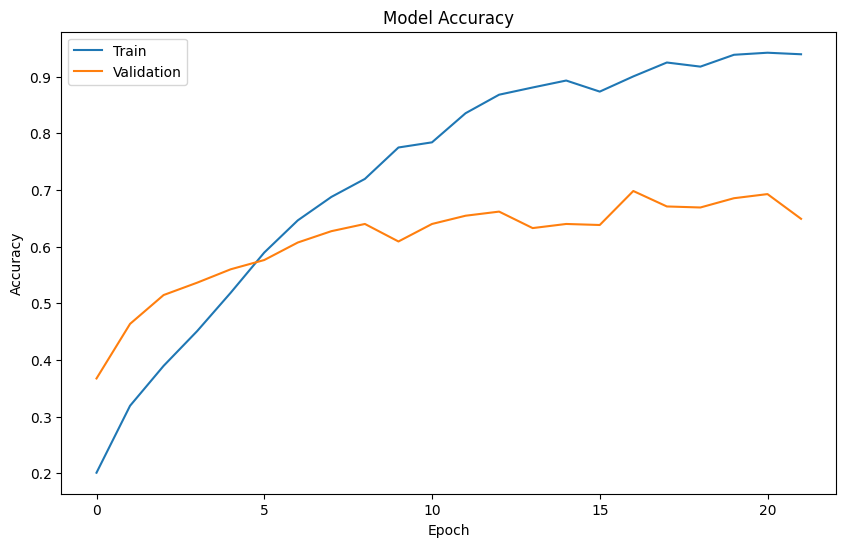

In [14]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


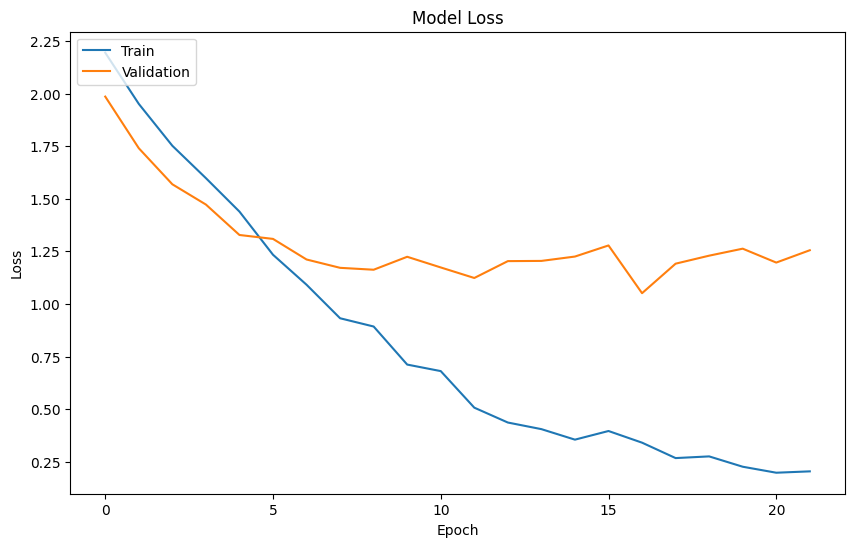

In [15]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


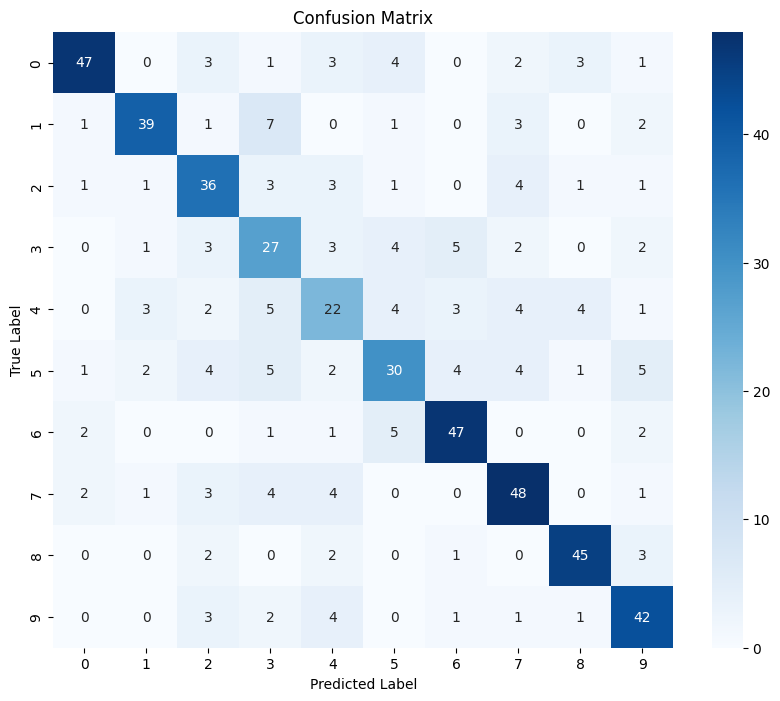

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test set
# y_pred = model.predict(val_dataset)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test.values, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [17]:
dict_map = {"0": "HTC-1-M7", 
            "1": "LG-Nexus-5x", 
            "2": "Motorola-Droid-Maxx", 
            "3": "Motorola-Nexus-6", 
            "4": "Motorola-X", 
            "5": "Samsung-Galaxy-Note3",
            "6": "Samsung-Galaxy-S4",
            "7": "Sony-NEX-7",
            "8": "iPhone-4s",
            "9": "iPhone-6"}

55/55 [==============================] - 80s 1s/step


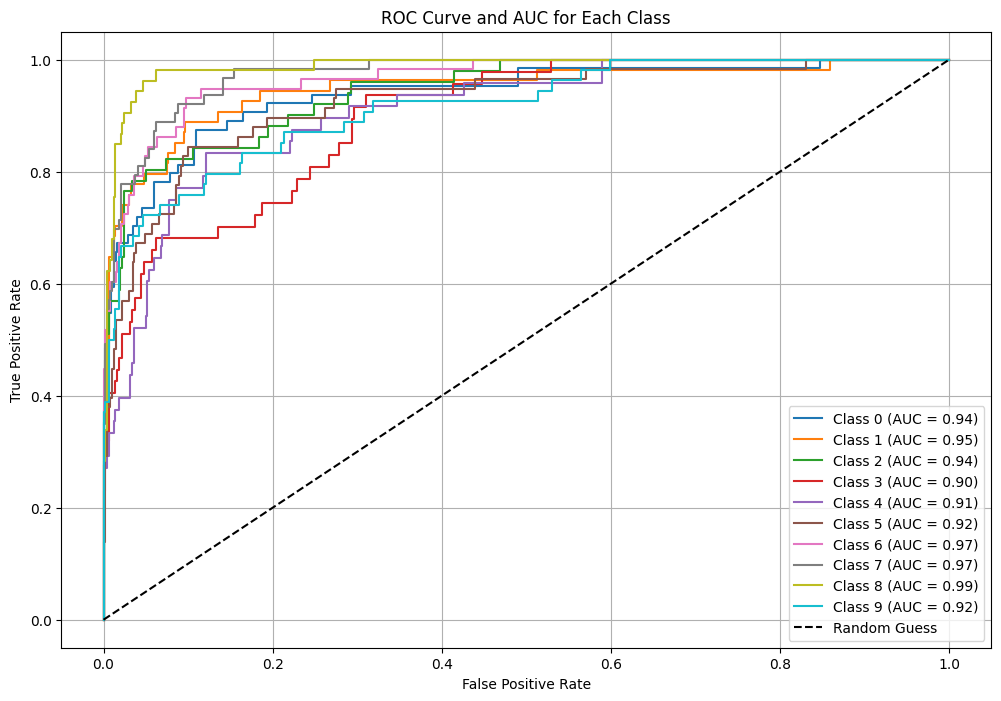

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict probabilities for X_test
y_pred_probs = model2.predict(X_test, batch_size=10)

# Ensure y_test is one-hot encoded
if len(y_test.shape) == 1:  # If y_test is in class indices
    from tensorflow.keras.utils import to_categorical
    y_test = to_categorical(y_test, num_classes=y_pred_probs.shape[1])  # Match num_classes

# Initialize plot
plt.figure(figsize=(12, 8))

# Calculate ROC and AUC for each class
for i in range(y_test.shape[1]):  # Loop through each class
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_probs[:, i])  # True and predicted probabilities for class i
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Set plot labels and title
plt.title('ROC Curve and AUC for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()
